In [1]:
#..MODIFIED BY CHUYAN at Nov.12nd, this file was intended to test for a procedure of read various GCM dataset and automatically analysis:;
#..their behaviors of how LWP(TWP) amount changes with CCFs and to build a (linear) regression model to predict these change;
#..among these process, we wish to examine a way to automatically distinguish these LRMs and determine their threshold;



import netCDF4
from numpy import *
import matplotlib.pyplot as plt
import xarray as xr
import PyNIO as Nio
import pandas as pd
import glob
from scipy.stats import *
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm

from area_mean import *
from binned_cyFunctions5 import *
from read_hs_file import read_var_mod
from get_LWPCMIP6data import *
from get_annual_so import *
from calc_LRM_metrics import *
from fitLRM_cy import *
from run_simple_cmip6 import *
from calc_slope import *

In [2]:
exp = 'abrupt-4xCO2'

SAM0={'modn': 'SAM0-UNICON', 'consort': 'SNU', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}

BCCESM1 = {'modn': 'BCC-ESM1', 'consort': 'BCC', 'cmip': 'cmip6',
           'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}

CESM2FV2 = {'modn': 'CESM2-FV2', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
HADGEM3 = {'modn': 'HadGEM3-GC31-LL', 'consort': 'MOHC', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f3', 'gg': 'gn', "typevar": 'Amon'}

CanESM5 = {'modn': 'CanESM5', 'consort': 'CCCma', 'cmip': 'cmip6', 'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}

CESM2 = {'modn': 'CESM2', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}

#C_dict  =   calc_LRM_metrics(**CESM2)
#A, b   = calc_LRM_metrics(**CESM2)

In [9]:
def p4plot1(rawdata_dict, s_range, y_range, x_range, shape_yr_pi, shape_yr_abr):
    # 's_range , 'y_range', 'x_range' used to do area mean for repeat gmt ARRAY
    
    # retriving datas from big dict...
    dict0_abr_var = rawdata_dict['dict0_abr_var']
    dict0_PI_var  = rawdata_dict['dict0_PI_var']
    #print(dict0_PI_var['times'])

    model = rawdata_dict['model_data']   #.. type in dict

    datavar_nas = ['LWP', 'TWP', 'IWP', 'PRW', 'SST', 'p_e', 'LTS', 'SUB']   #..8 varisables except gmt (lon dimension diff)

    # load annually-mean bin data
    dict1_yr_bin_PI  = dict0_PI_var['dict1_yr_bin_PI']
    dict1_yr_bin_abr  = dict0_abr_var['dict1_yr_bin_abr']
    
    # load monthly bin data
    ###
    # calc area-mean ARRAY FOR variables:
    
    areamean_dict_PI = {}
    areamean_dict_abr  = {}
    areamean_dict_predi =  {}
    
    for e in range(len(datavar_nas)):
        
        areamean_dict_PI[datavar_nas[e]+ '_area_yr'] =  area_mean(dict1_yr_bin_PI[datavar_nas[e]+ '_yr_bin'], y_range, x_range)
        areamean_dict_abr[datavar_nas[e]+ '_area_yr'] =  area_mean(dict1_yr_bin_abr[datavar_nas[e]+ '_yr_bin'], y_range, x_range)
      
    
    areamean_dict_predi['LWP_area_yr_pi']  =   area_mean(rawdata_dict['LWP_predi_bin_PI'], y_range, x_range)
    areamean_dict_predi['LWP_area_yr_abr']  =   area_mean(rawdata_dict['LWP_predi_bin_abr'], y_range, x_range)
    areamean_dict_predi['IWP_area_yr_pi']   =    area_mean(rawdata_dict['IWP_predi_bin_PI'], y_range, x_range)
    areamean_dict_predi['IWP_area_yr_abr']   =    area_mean(rawdata_dict['IWP_predi_bin_abr'], y_range, x_range)
    
    areamean_dict_PI['gmt_area_yr']  =  area_mean(dict1_yr_bin_PI['gmt_yr_bin'], s_range, x_range)
    areamean_dict_abr['gmt_area_yr']  =  area_mean(dict1_yr_bin_abr['gmt_yr_bin'], s_range, x_range)
    
    
    rawdata_dict['areamean_dict_predi'] =  areamean_dict_predi
    rawdata_dict['areamean_dict_abr']   =  areamean_dict_abr
    rawdata_dict['areamean_dict_PI']    =  areamean_dict_PI
    
    
    # genarate some array convenient for plotting
    #..Years from pi-control to abrupt4xCO2 experiment, which are choosed years
    Yrs =  arange(shape_yr_pi+shape_yr_abr)
    
    # Global-mean surface air temperature, from pi-control to abrupt4xCO2 experiment
    
    GMT =  full((shape_yr_pi+shape_yr_abr),  0.0)
    GMT[0:shape_yr_pi]  =   areamean_dict_PI['gmt_area_yr']
    GMT[shape_yr_pi:]  =   areamean_dict_abr['gmt_area_yr']
    
    # predicted values, from pi-Control to abrupt4xCO2 experiment
    
    predict_lwp  = full((shape_yr_pi + shape_yr_abr), 0.0)
    predict_lwp[0:shape_yr_pi]  =   areamean_dict_predi['LWP_area_yr_pi']
    predict_lwp[shape_yr_pi:]  =   areamean_dict_predi['LWP_area_yr_abr']
    
    predict_iwp  = full((shape_yr_pi + shape_yr_abr), 0.0)
    predict_iwp[0:shape_yr_pi]  =   areamean_dict_predi['IWP_area_yr_pi']
    predict_iwp[shape_yr_pi:]  =   areamean_dict_predi['IWP_area_yr_abr']
    
    # reported values, from pi-Conrol to abrupt4xCO2 experiment
    
    report_lwp  =   full((shape_yr_pi + shape_yr_abr), 0.0)
    report_lwp[0:shape_yr_pi]  =   areamean_dict_PI['LWP_area_yr']
    report_lwp[shape_yr_pi:]   =  areamean_dict_abr['LWP_area_yr']
    
    report_iwp  =   full((shape_yr_pi + shape_yr_abr), 0.0)
    report_iwp[0:shape_yr_pi]  =   areamean_dict_PI['IWP_area_yr']
    report_iwp[shape_yr_pi:]   =  areamean_dict_abr['IWP_area_yr']
    
    
    # put them into the rawdata_dict:
    rawdata_dict['Yrs']  = Yrs
    rawdata_dict['GMT']  =   GMT
    
    rawdata_dict['predict_lwp']  =  predict_lwp
    rawdata_dict['report_lwp']  =   report_lwp
    
    
    rawdata_dict['predict_iwp']  = predict_iwp
    rawdata_dict['report_iwp']   = report_iwp
    

    return rawdata_dict

In [10]:
x_range  = arange(-180., 183, 5.)   #..logitude sequences edge: number:73
s_range  = arange(-90., 90, 5.) + 2.5   #..global-region latitude edge:(36)

y_range  = arange(-85, -35., 5.) +2.5   #..southern-ocaen latitude edge:10

shape_yr_pi = 99
shape_yr_abr = 151

rawdata_dict = p4plot1(C_dict, s_range, y_range, x_range, shape_yr_pi, shape_yr_abr)

In [8]:
main()

oh! we have data in model:  GISS-E2-1-G
['/glade/collections/cmip/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/abrupt-4xCO2/r1i1p1f1/Amon/ps/gn/v20181002/ps/']
/glade/collections/cmip/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/abrupt-4xCO2/r1i1p1f1/Amon/ps/gn/v20181002/ps/ps_Amon_GISS-E2-1-G_abrupt-4xCO2_r1i1p1f1_gn_195101-200012.nc
/glade/collections/cmip/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/abrupt-4xCO2/r1i1p1f1/Amon/ps/gn/v20181002/ps/ps_Amon_GISS-E2-1-G_abrupt-4xCO2_r1i1p1f1_gn_190101-195012.nc
/glade/collections/cmip/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/abrupt-4xCO2/r1i1p1f1/Amon/ps/gn/v20181002/ps/ps_Amon_GISS-E2-1-G_abrupt-4xCO2_r1i1p1f1_gn_185001-190012.nc
(1812, 90, 144)
[1850, 1, 1] [1999, 12, 31]
['/glade/collections/cmip/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/abrupt-4xCO2/r1i1p1f1/Amon/ts/gn/v20181002/ts/']
/glade/collections/cmip/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/abrupt-4xCO2/r1i1p1f1/Amon/ts/gn/v20181002/ts/ts_Amon_GISS-E2-1-G_abrupt-4xCO2_r1i1p1f1_gn_185001-190012.nc
/glade/collections/cmip/CMIP6/CMIP/NASA-

In [2]:
deck_nas  = ['BCCESM1', 'CanESM5', 'CESM2', 'CESM2FV2', 'CESM2WACCM', 'CNRMESM2', 'GISSE21G', 'GISSE21H', 'IPSLCM6ALR', 'MRIESM20', 'MIROC6', 'SAM0']

SAM0={'modn': 'SAM0-UNICON', 'consort': 'SNU', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GISSE21G = {'modn': 'GISS-E2-1-G', 'consort': 'NASA-GISS', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2 = {'modn': 'CESM2', 'consort': 'NCAR', 'cmip': 'cmip6',
         'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}

if (exp=='piControl')|(exp=='amip'):

    MIROC6 = {'modn': 'MIROC6', 'consort': 'MIROC', 'cmip': 'cmip6',
          'exper': exp, 'ensmem': 'r2i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
    CAMSCSM1 = {'modn': 'CAMS-CSM1-0', 'consort': 'CAMS', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}

CESM2FV2 = {'modn': 'CESM2-FV2', 'consort': 'NCAR', 'cmip': 'cmip6',
         'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}

GISSE21H = {'modn': 'GISS-E2-1-H', 'consort': 'NASA-GISS', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}

CESM2WACCM = {'modn': 'CESM2-WACCM', 'consort': 'NCAR', 'cmip': 'cmip6',
         'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
HADGEM3 = {'modn': 'HadGEM3-GC31-LL', 'consort': 'MOHC', 'cmip': 'cmip6',
           'exper': exp, 'ensmem': 'r1i1p1f3', 'gg': 'gn', "typevar": 'Amon'}   #  Be careful, failure due to 'day time representation'
UKESM10 = {'modn': 'UKESM1-0-LL', 'consort': 'MOHC', 'cmip': 'cmip6',
           'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gn', "typevar": 'Amon'}   # the same day time representation issue as 'HadGem3', dont have 'wap' variable in 'pi-Control' exp
IPSLCM6ALR = {'modn': 'IPSL-CM6A-LR', 'consort': 'IPSL', 'cmip': 'cmip6',
              'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}
CNRMCM6 = {'modn': 'CNRM-CM6-1', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip6',
           'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gr', "typevar": 'Amon'}# time doesn't corresponding for 'evspsbl' in  'pi-Control' exper

CNRMESM2 = {'modn': 'CNRM-ESM2-1', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip6', 
           'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gr', "typevar": 'Amon'}
MIROC6 = {'modn': 'MIROC6', 'consort': 'MIROC', 'cmip': 'cmip6',
          'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
MIROCES2L= {'modn': 'MIROC-ES2L', 'consort': 'MIROC', 'cmip': 'cmip6',
          'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gn', "typevar": 'Amon'}#


GFDLCM4 = {'modn': 'GFDL-CM4', 'consort': 'NOAA-GFDL', 'cmip': 'cmip6',
           'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr1', "typevar": 'Amon'}# missing lots of Variables
BCCESM1 = {'modn': 'BCC-ESM1', 'consort': 'BCC', 'cmip': 'cmip6',
           'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
ACCESSCM2 = {'modn': 'ACCESS-CM2', 'consort': 'CSIRO-ARCCSS', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}#..'/glade/' don't have 'Amon' typevar
CAMSCSM1 = {'modn': 'CAMS-CSM1-0', 'consort': 'CAMS', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r2i1p1f1', 'gg': 'gn', "typevar": 'Amon'}#  abrupt4x exper doesnt have 'ps' variable in r1i1p1f1
MPIESM12LR = {'modn': 'MPI-ESM1-2-LR', 'consort': 'MPI-M', 'cmip': 'cmip6',
              'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}#..'/glade/' dont have 'Amon' typevar
CanESM5 = {'modn': 'CanESM5', 'consort': 'CCCma', 'cmip': 'cmip6',
           'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
INM_CM48 = {'modn': 'INM-CM4-8', 'consort': 'INM', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr1', "typevar": 'Amon'}#..'/glade/' dont have 'Amon' typevar
INM_CM50 = {'modn': 'INM-CM5-0', 'consort': 'INM', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr1', "typevar": 'Amon'}#..'/glade/' dont have 'Amon' typevar

NORESM2LM = {'modn': 'NorESM2-LM', 'consort': 'NCC', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}# missing a lot of variables and typevars
E3SM10 = {'modn': 'E3SM-1-0', 'consort': 'E3SM-Project', 'cmip': 'cmip6',
          'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}# time doesnt corresponding, lose a lot of files for different variables in both exper
AWICM11MR = {'modn': 'AWI-CM-1-1-MR', 'consort': 'AWI', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}#..'/glade/' dont have 'tas' variable
CMCC = {'modn': 'CMCC-CM2-SR5', 'consort': 'CMCC', 'cmip': 'cmip6',
        'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'} #..'/glade/' dont have 'abrupt-4xCO2'/'piControl' exper
ECE = {'modn': 'EC-Earth3', 'consort': 'EC-Earth-Consortium', 'cmip': 'cmip6',
       'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'} #..dont have 'Amon' or variable 'tas'
#ECE has different variants for exper
ECEV = {'modn': 'EC-Earth3-Veg', 'consort': 'EC-Earth-Consortium', 'cmip': 'cmip6',
       'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}#..too hard to operate

#ECEV has very discrete year in 'abrupt-4xCO2', semms continued but each in one yr file in 'piControl'
MRIESM20 = {'modn': 'MRI-ESM2-0', 'consort': 'MRI', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
FGOALSg3 = {'modn': 'FGOALS-g3', 'consort': 'CAS', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}# '/glade/' dont have 'Amon' typever in 'abru4x'


deck  = [BCCESM1, CanESM5, CESM2, CESM2FV2, CESM2WACCM, CNRMESM2, GISSE21G, GISSE21H, IPSLCM6ALR, MRIESM20, MIROC6, SAM0]

output_ARRAY = {}
output_intermedia = {}
output_GMT =  {}
output_predict  = {}
output_report   = {}

output_dict0_PI =  {}
output_dict0_abr = {}
shape_yr_modelPI =  {}
shape_yr_modelabr = {}

Tr_sst =  276.15

for i in range(len(deck)):
    
    output_ARRAY[deck_nas[i]] =  load(deck[i]['modn']+'_'+str(Tr_sst)+'_dats.npz', allow_pickle=True)  #+'_'+str(Tr_sst)
    output_intermedia[deck_nas[i]]  = output_ARRAY[deck_nas[i]]['rawdata_dict']
    
    output_GMT[deck_nas[i]]  =   output_intermedia[deck_nas[i]][()]['GMT']
    output_predict[deck_nas[i]]  =   output_intermedia[deck_nas[i]][()]['predict_lwp']
    output_report[deck_nas[i]]  =   output_intermedia[deck_nas[i]][()]['report_lwp']

    output_dict0_PI[deck_nas[i]]  =   output_intermedia[deck_nas[i]][()]['dict0_PI_var']
    output_dict0_abr[deck_nas[i]]  =   output_intermedia[deck_nas[i]][()]['dict0_abr_var']
    shape_yr_modelPI[deck_nas[i]]   =  output_dict0_PI[deck_nas[i]]['shape_yr']
    shape_yr_modelabr[deck_nas[i]]   =  output_dict0_abr[deck_nas[i]]['shape_yr']

print(shape_yr_modelPI, shape_yr_modelabr)

{'BCCESM1': 99, 'CanESM5': 99, 'CESM2': 99, 'CESM2FV2': 99, 'CESM2WACCM': 99, 'CNRMESM2': 99, 'GISSE21G': 99, 'GISSE21H': 99, 'IPSLCM6ALR': 99, 'MRIESM20': 99, 'MIROC6': 99, 'SAM0': 99} {'BCCESM1': 150, 'CanESM5': 150, 'CESM2': 150, 'CESM2FV2': 150, 'CESM2WACCM': 150, 'CNRMESM2': 150, 'GISSE21G': 150, 'GISSE21H': 150, 'IPSLCM6ALR': 150, 'MRIESM20': 150, 'MIROC6': 150, 'SAM0': 150}


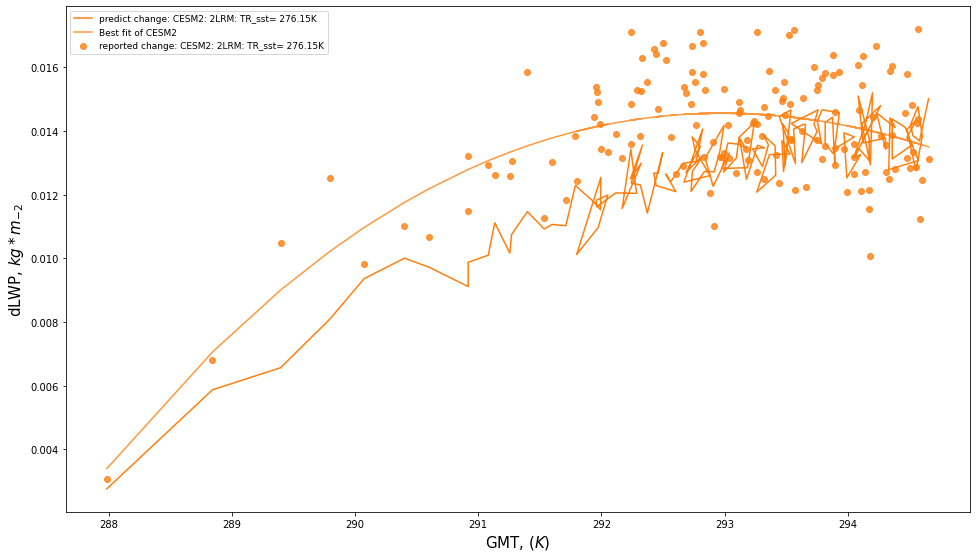

In [7]:
#.. abrupt+piC  Plot:

fig3, ax4  = plt.subplots(1, 1, figsize =(16.2, 9.3))   #(16.2, 9.3))
#ax3  = plt.axes()


# These are the colors that will be used in the plot
'''
ax4.set_prop_cycle(color=[
        '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
        '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
        '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
        '#17becf', '#9edae5'])
'''
my_colors= array([
        '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
        '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
        '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
        '#17becf', '#9edae5'])   #..plt.rcParams['axes.prop_cycle']()
my_colorst= my_colors

output_dabrmeanpi_report = {}
output_dabrmeanpi_predict = {}

output_yrs = {}

for a in range(len(deck)):
    output_yrs[deck_nas[a]]  = arange(shape_yr_modelPI[deck_nas[a]]+shape_yr_modelabr[deck_nas[a]])
    
    #..if deck_nas[a]=='CESM2'or deck_nas[a]=='CESM2FV2' or deck_nas[a]=='CESM2WACCM':   
    #..if deck_nas[a]!='BCCESM1':   #..BCCESM1
    if deck_nas[a] =='CESM2':
        output_dabrmeanpi_report[deck_nas[a]] = output_report[deck_nas[a]][shape_yr_modelPI[deck_nas[a]]:] - mean(output_report[deck_nas[a]][0:shape_yr_modelPI[deck_nas[a]]])
        output_dabrmeanpi_predict[deck_nas[a]] = output_predict[deck_nas[a]][shape_yr_modelPI[deck_nas[a]]:] - mean(output_predict[deck_nas[a]][0:shape_yr_modelPI[deck_nas[a]]])
        
        ax4.scatter(output_GMT[deck_nas[a]][shape_yr_modelPI[deck_nas[a]]: shape_yr_modelPI[deck_nas[a]]+149], output_dabrmeanpi_report[deck_nas[a]][0:149], label='reported change: '+deck_nas[a]+': 2LRM: TR_sst= 276.15K', alpha =0.8, c= my_colors[a]) 
        ax4.plot(output_GMT[deck_nas[a]][shape_yr_modelPI[deck_nas[a]]: shape_yr_modelPI[deck_nas[a]]+149], output_dabrmeanpi_predict[deck_nas[a]][0:149], label='predict change: '+deck_nas[a]+': 2LRM: TR_sst= 276.15K', alpha = 1.0, c = my_colors[a])
        
        #plt.scatter(output_GMT[deck_nas[a]][0: 248], output_report[deck_nas[a]][0: 248], label='reported LWP: ' + deck_nas[a])
        #plt.plot(output_GMT[deck_nas[a]][0: 248], output_predict[deck_nas[a]][0: 248], label = 'predict LWP: ' + deck_nas[a])
        
        GMT = output_GMT[deck_nas[a]][shape_yr_modelPI[deck_nas[a]]:shape_yr_modelPI[deck_nas[a]]+149]
        Yrs = output_yrs[deck_nas[a]][shape_yr_modelPI[deck_nas[a]]:shape_yr_modelPI[deck_nas[a]]+149]
        
        parameter = polyfit(GMT, output_dabrmeanpi_report[deck_nas[a]][0:149],3)
        #z1  = poly1d(parameter)
        #print(z1)
        y2 = parameter[0]*GMT**3 + parameter[1]*GMT**2 +parameter[2]*GMT + parameter[3]

        ax4.plot(GMT, y2, label='Best fit of '+ deck_nas[a], alpha=0.8, c = my_colors[a])
'''
for b in range(len(deck)):
    
    #if deck_nas[a]=='CESM2'or deck_nas[a]=='CESM2FV2' or deck_nas[a]=='CESM2WACCM':   #..BCCESM1
    if deck_nas[b]!='BCCESM1':   #..BCCESM1
'''


plt.xlabel('GMT, '+ r'$(K)$', fontsize= 15)
plt.ylabel('dLWP, '+r'$kg*m_{-2}$', fontsize= 15)
#plt.title("Changes of LWP | abr4x - mean(pi-C) for GISSE21H and the ployfit", fontsize =19)

ax4.legend(loc='upper left', fontsize= 9)   #..loc='best', bbox_to_anchor=(-0.55, 0.38, 0.5, 0.63)

#..plt.savefig('CESM2 & variants_276K_ 2lrm')
#plt.savefig("Linear_Regression_multiple models_abrupt4x&pi-C_ 0K_ overgmt.png")
#plt.savefig('LWP changes from meanstate to abr_ 270K _ overgmt')

#plt.savefig('CanESM5_over gmt_ 2 lrm')
#plt.savefig('Variabilities of liquid-cloud amount(LWP) in 11 GCM_ 2lrm_ 276K')

#plt.savefig("best fit CESM2")

(149,)
(149,)
(149,)
(149,)
(149,)
(149,)
(149,)
(149,)
(149,)
(149,)
(149,)


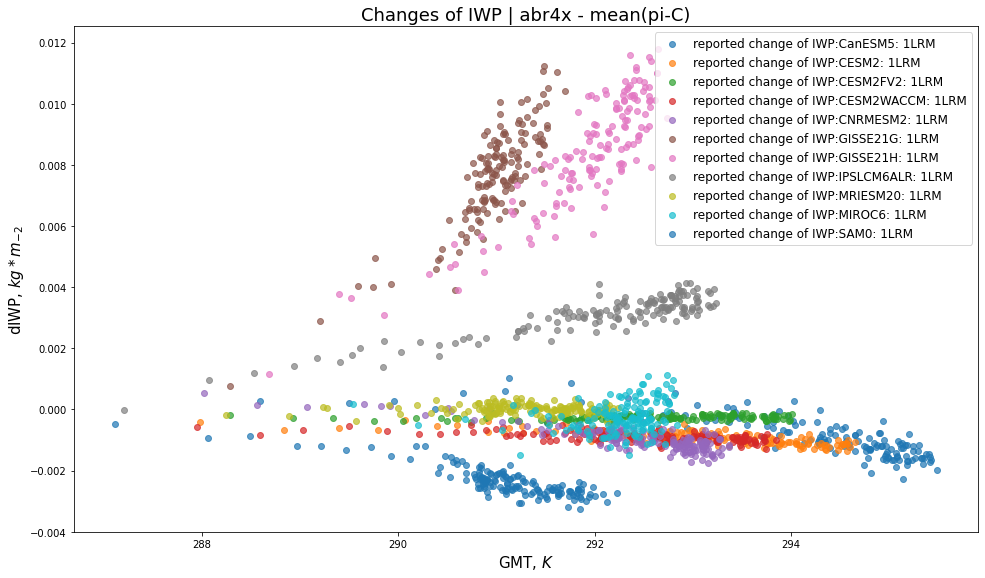

In [33]:
#.. abrupt+piC Plot for Ice Water Path:

fig3  = plt.figure(figsize = (16.2, 9.3))  #(16.2, 9.3))
ax3  = plt.axes()

output_yr_abr= {}
output_yr_PI = {}

output_IWP_PI = {}
output_IWP_abr = {}
#..set are-mean range and define functio
x_range  = arange(-180., 183, 5.)   #..logitude sequences edge: number:73
s_range  = arange(-90., 90, 5.) + 2.5   #..global-region latitude edge:(36)

y_range  = arange(-85, -35., 5.) +2.5   #..southern-ocaen latitude edge:10


output_dabrmeanpi_report = {}
output_dabrmeanpi_predict = {}

for a in range(len(deck)):
    
    output_yr_PI[deck_nas[a]]  = output_dict0_PI[deck_nas[a]]['dict1_yr_bin_PI']
    output_yr_abr[deck_nas[a]]  = output_dict0_abr[deck_nas[a]]['dict1_yr_bin_abr']
    
    
    output_IWP_abr[deck_nas[a]] = area_mean(output_yr_abr[deck_nas[a]]['IWP_yr_bin'], y_range, x_range)
    output_IWP_PI[deck_nas[a]] = area_mean(output_yr_PI[deck_nas[a]]['IWP_yr_bin'], y_range, x_range)
    #print(output_IWP_PI[deck_nas[a]].shape)
    
    #if deck_nas[a]=='CESM2'or deck_nas[a]=='CESM2FV2' or deck_nas[a]=='CESM2WACCM':   #.. BCCESM1
    if deck_nas[a]!='BCCESM1':
        
        output_dabrmeanpi_report[deck_nas[a]] = output_IWP_abr[deck_nas[a]][0:149] - mean(output_IWP_PI[deck_nas[a]])
        print(output_dabrmeanpi_report[deck_nas[a]].shape)
        
        plt.scatter(output_GMT[deck_nas[a]][99:248], output_dabrmeanpi_report[deck_nas[a]], label='reported change of IWP:'+deck_nas[a]+': 1LRM', alpha =0.7) 
        #plt.plot(output_GMT[deck_nas[a]][99:249], output_dabrmeanpi_predict[deck_nas[a]], label='predict change: '+deck_nas[a]+': 1LRM', alpha =1)
        
        #plt.scatter(output_GMT[deck_nas[a]][0: 248], output_report[deck_nas[a]][0: 248], label='reported LWP: ' + deck_nas[a])
        #plt.plot(output_GMT[deck_nas[a]][0: 248], output_predict[deck_nas[a]][0: 248], label = 'predict LWP: ' + deck_nas[a])
            
            
plt.xlabel('GMT, '+ r'$K$', fontsize= 15)
plt.ylabel('dIWP, '+r'$kg*m_{-2}$', fontsize= 15)
plt.title("Changes of IWP | abr4x - mean(pi-C)", fontsize =18)

plt.legend(loc='upper right',  fontsize= 12)

#plt.savefig("Linear_Regression_multiple models_abrupt4x&pi-C_ 0K_ overgmt.png")
#plt.savefig('LWP changes from meanstate to abr_ 0K_ overgmt')
#plt.savefig('CESM2 & variants')

#plt.savefig('Variabilities of liquid-cloud amount(LWP) in 11 GCM')
#plt.savefig('Variabilities of IWP in 11GCMs')

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

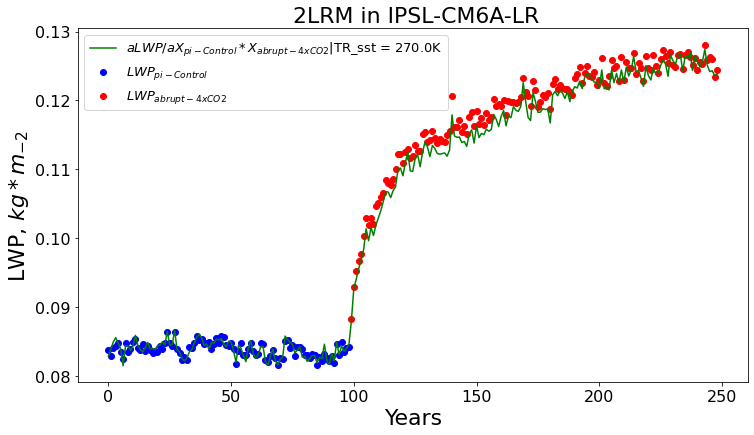

In [31]:
#..abrupt+piC Plot:

fig2  = plt.figure(figsize = (12, 6.5))
ax2  = plt.axes()
parameters = {'axes.labelsize': 22, 'legend.fontsize': 13,
          'axes.titlesize': 22, 'xtick.labelsize': 16, 'ytick.labelsize':16}
plt.rcParams.update(parameters)

#deck  = [BCCESM1, CanESM5, CESM2, CESM2FV2, CESM2WACCM, CNRMESM2, GISSE21G, GISSE21H, IPSLCM6ALR, MRIESM20, MIROC6, SAM0]
xiu = arange(0, shape_yr_modelPI[deck_nas[8]]+150)
print(xiu)

output_yrs = {}
for b in range(len(deck_nas)):
    if deck_nas[b] == 'IPSLCM6ALR':
        
        output_yrs[deck_nas[b]] = arange(0, shape_yr_modelPI[deck_nas[b]]+150)
        print(output_yrs[deck_nas[b]].shape)
        plt.scatter(output_yrs[deck_nas[b]][:99], output_report[deck_nas[b]][:99], label='$LWP_{pi-Control} $', c='b')
        
        plt.scatter(output_yrs[deck_nas[b]][99:249], output_report[deck_nas[b]][99:249], label='$LWP_{abrupt-4xCO2} $', c= 'r')
        plt.plot(output_yrs[deck_nas[b]], output_predict[deck_nas[b]][:249], "g", label='$aLWP/aX_{pi-Control}*{X_{abrupt-4xCO2}}| $'+'TR_sst = 270.0K')
        


print(array(output_yrs).shape)

plt.xlabel('Years', fontsize=22)
        
plt.ylabel('LWP, '+r'$kg *m_{-2}$', fontsize=22)
plt.title(" 2LRM in IPSL-CM6A-LR", fontsize=22)  #..!!
plt.legend( )
#plt.ylim((0.105, 0.121))

#plt.savefig("Schematic_2LRM 270K_ IPSLCM6ALR")


In [8]:
BCCESM1file = load('BCC-ESM1_dats.npz', allow_pickle=True)

dict0 = BCCESM1file['rawdata_dict']

#dict0['GMT']

dict_temp=dict0[()]
dict_temp['report_lwp']

array([1.46713051, 1.47679691, 1.49106991, 1.48114069, 1.47301551,
       1.48499002, 1.48279961, 1.49713408, 1.46532758, 1.48168947,
       1.46957865, 1.46016456, 1.44993756, 1.46222871, 1.47494793,
       1.45555035, 1.46568768, 1.45189751, 1.44321572, 1.48528434,
       1.48626502, 1.47152547, 1.42369055, 1.47557189, 1.47483218,
       1.48210439, 1.44309394, 1.47213658, 1.49445832, 1.47845301,
       1.48367962, 1.47218181, 1.46485639, 1.46010476, 1.48397386,
       1.48598172, 1.48611355, 1.46228268, 1.44902086, 1.48714533,
       1.50337866, 1.47854867, 1.46668079, 1.46691694, 1.48482622,
       1.46640888, 1.46476549, 1.47282729, 1.47168823, 1.49224482,
       1.49734571, 1.47960091, 1.46975343, 1.48797607, 1.45932258,
       1.46100636, 1.48717739, 1.46803886, 1.47494413, 1.48196999,
       1.46010344, 1.46554829, 1.45478683, 1.48352608, 1.47162679,
       1.49338144, 1.46242344, 1.45460769, 1.46018112, 1.46422474,
       1.46161877, 1.46934186, 1.46476288, 1.47854774, 1.46867